In [130]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
from torch import nn, Tensor

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2

import time
import math
import copy

from tensorflow_docs.vis import embed

from torchvision.models import densenet121, DenseNet121_Weights
from torchnlp.encoders import LabelEncoder
import numpy as np

In [89]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1000
IMG_SIZE = 128

In [128]:
# 将数据分为：训练集、验证集、测试集
train_df = pd.read_csv("train_new.csv")
val_df = pd.read_csv("val_new.csv")
test_df = pd.read_csv("test_new.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for training: {len(val_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 569
Total videos for training: 25
Total videos for testing: 224


In [120]:
# 定义 CenterCrop 类
class CenterCrop(object):
	"""Crop the center area from images.
	Args:
		crop_size (int | tuple[int]): (w, h) of crop size.
	"""
	# size=128
	def __init__(self, size):
		self.size = size
		self._center_crop = transforms.CenterCrop(size)

	def __call__(self, frame):
		# 将 frame 变为 tensor
		frame = torch.from_numpy(frame)
		# torch.Size([240, 320, 3])
		frame = torch.permute(frame, (2, 0, 1))
		# torch.Size([3, 240, 320])
		frame = frame[None, ...]
		# torch.Size([1, 3, 240, 320])
		# transforms.CenterCrop 的输入应为： […, H, W] ，即 H 和 W 应该在最后两维，所以需要 permute 调整顺序
		frame = self._center_crop(frame)
		# torch.Size([1, 3, 128, 128])
		frame = torch.permute(frame, (0, 2, 3, 1))
		# torch.Size([1, 128, 128, 3])
		frame = frame.numpy().squeeze()
		# (128, 128, 3)
		return frame

In [127]:
# 定义 load_video 方法
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = CenterCrop(IMG_SIZE)(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [114]:
# 对输入做预处理
# transforms.ToTensor：Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# transforms.Normalize：Normalize a tensor image with mean and standard deviation。mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] 是 imageNet 的 mean 和 std
# link: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [236]:
# 定义 feature extractor
def build_feature_extractor():
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)

    return model.eval().to(device)

In [238]:
feature_extractor = build_feature_extractor()
label_processor = LabelEncoder(np.unique(train_df["tag"]), reserved_labels=['unknown'], unknown_index=0)

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor.batch_encode(labels) # 所有 label 都在一个数组里，eg: [1, 2, 3, 1]
    labels = labels[..., None].numpy() # 每个 label 都是一个单独的数据，eg: [[1], [2], [3], [1]]
    

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path)) # 获得当前视频的所有帧
        print(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # 对视频中的每帧做处理
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    cur_input = preprocess(batch[j, :]).unsqueeze(0).to(device)
                    # input 需要先 unsqueeze(0) 才能进入预训练模型
                    temp_frame_features[i, j, :] = feature_extractor(cur_input).cpu().detach().numpy()
                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [239]:
# 这里原本应该调用 prepare_all_video 方法来获得 train_data, train_labels 和 test_data, test_labels
train_data, train_labels = prepare_all_videos(train_df, './train')
val_data, val_labels = prepare_all_videos(val_df, './train')
test_data, test_labels = prepare_all_videos(test_df, './test')

np.save('train_data_new.npy', train_data)
np.save('train_labels_new.npy', train_labels)
np.save('val_data_new.npy', val_data)
np.save('val_labels_new.npy', val_labels)
np.save('test_data_new.npy', test_data)
np.save('test_labels_new.npy', test_labels)

./train/v_CricketShot_g08_c01.avi
./train/v_CricketShot_g08_c02.avi
./train/v_CricketShot_g08_c03.avi
./train/v_CricketShot_g08_c04.avi
./train/v_CricketShot_g08_c05.avi
./train/v_CricketShot_g08_c06.avi
./train/v_CricketShot_g08_c07.avi
./train/v_CricketShot_g09_c01.avi
./train/v_CricketShot_g09_c02.avi
./train/v_CricketShot_g09_c03.avi
./train/v_CricketShot_g09_c04.avi
./train/v_CricketShot_g09_c05.avi
./train/v_CricketShot_g09_c06.avi
./train/v_CricketShot_g09_c07.avi
./train/v_CricketShot_g10_c01.avi
./train/v_CricketShot_g10_c02.avi
./train/v_CricketShot_g10_c03.avi
./train/v_CricketShot_g10_c04.avi
./train/v_CricketShot_g10_c05.avi
./train/v_CricketShot_g10_c06.avi
./train/v_CricketShot_g10_c07.avi
./train/v_CricketShot_g11_c01.avi
./train/v_CricketShot_g11_c02.avi
./train/v_CricketShot_g11_c03.avi
./train/v_CricketShot_g11_c04.avi
./train/v_CricketShot_g11_c05.avi
./train/v_CricketShot_g11_c06.avi
./train/v_CricketShot_g11_c07.avi
./train/v_CricketShot_g12_c01.avi
./train/v_Cric

In [240]:
# train_data, train_labels = np.load("train_data_new.npy"), np.load("train_labels_new.npy")
# val_data, val_labels = np.load("val_data_new.npy"), np.load("val_labels_new.npy")
# test_data, test_labels = np.load("test_data_new.npy"), np.load("test_labels_new.npy")

In [241]:
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in train set: {val_data.shape}")
print(f"Frame features in train set: {test_data.shape}")

print(train_labels.shape)
print(val_labels.shape)

Frame features in train set: (569, 20, 1000)
Frame features in train set: (25, 20, 1000)
Frame features in train set: (224, 20, 1000)
(569, 1)
(25, 1)


In [242]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
    
    def forward(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        positions = torch.arange(0, MAX_SEQ_LENGTH)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [243]:
classes = len(np.unique(train_df["tag"]))
# init 定义 Encoder 每个模块；forward 实际调用每个模块，将模块关联在一起
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim =  dense_dim
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads, dropout=0.3
        )
        self.dense_proj = nn.Sequential(
            nn.Linear(embed_dim, dense_dim*embed_dim),
            nn.GELU(),
            nn.Linear(dense_dim*embed_dim, embed_dim)
        )

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, classes),
            nn.Softmax() # 对输出做归一化处理，将元素转换为 0 到 1 之间，且所有元素相加为 1
        )

        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.layernorm_2 = nn.LayerNorm(embed_dim)
    
    def forward(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, inputs, attn_mask=mask)[0]
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        output = self.layernorm_2(proj_output + proj_input)
        # x = nn.MaxPool1d(3, stride=2)(output)
        output_dropout = nn.Dropout(0.5)(output)
        # x = nn.Linear(self.embed_dim, classes)(output_dropout)
        x = self.ffn(output_dropout)
        
        return x

In [244]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [245]:
sequence_length = MAX_SEQ_LENGTH
embed_dim = NUM_FEATURES
dense_dim = 4
num_heads = 1
classes = len(np.unique(train_df["tag"]))

model = TransformerEncoder(embed_dim, dense_dim, num_heads)
criterion = nn.CrossEntropyLoss()
lr = 0.0001  # learning rate
epochs = 30
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [246]:
def train(train_data, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to train mode
    model.train().to(device)

    total_loss = 0.
    log_interval = 20
    start_time = time.time()

    train_data_tensor = torch.from_numpy(train_data)

    for batch, i in enumerate(range(0, train_data_tensor.size(0))):
        # compute output
        input = train_data_tensor[i]
        pos_input = PositionalEmbedding(sequence_length, embed_dim)(input).to(device)

        output = model(pos_input).to(device)

        label = train_labels[i][0]

        # crossEntropy 的 target 类型是一维数组，每个元素是对应的 label
        target = torch.tensor(np.full((20,), label-1), dtype=torch.long).to(device)

        loss = criterion(output, target)

        # compute gradient and do update step
        optimizer.zero_grad()

        loss.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        optimizer.step()

        # measure accuracy and record loss
        total_loss = total_loss + loss.item()
        
        if i % log_interval == 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [247]:
def evaluate(model: nn.Module, val_data, criterion) -> float:
    model.eval().to(device) # turn on evaluation mode

    total_loss = 0.
    val_data_tensor = torch.from_numpy(val_data)
    
    with torch.no_grad():
        for i in range(0, val_data_tensor.size(0) - 1):
            cur_input = val_data_tensor[i].to(device)
            label = val_labels[i][0]
            target = torch.tensor(np.full((20,), label - 1), dtype=torch.long).to(device)
            
            output = model(cur_input)
            output_flat = output.view(-1, classes).to(device)
            total_loss = total_loss + criterion(output_flat, target).item()
    return total_loss / (len(val_data_tensor) - 1)

In [248]:
best_model = None
best_val_loss = 100.

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train(train_data, model, criterion, optimizer, epoch)

    val_loss = evaluate(model, val_data, criterion)
    val_ppl = math.exp(val_loss)

    elapsed = time.time() - epoch_start_time
    
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()


/home/cike/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


| epoch   1 | lr 0.0001 | ms/batch  0.46 | loss  0.07 | ppl     1.08
| epoch   1 | lr 0.0001 | ms/batch  6.12 | loss  1.55 | ppl     4.73
| epoch   1 | lr 0.0001 | ms/batch  6.54 | loss  1.52 | ppl     4.58
| epoch   1 | lr 0.0001 | ms/batch  6.21 | loss  1.50 | ppl     4.50
| epoch   1 | lr 0.0001 | ms/batch  5.92 | loss  1.50 | ppl     4.47
| epoch   1 | lr 0.0001 | ms/batch  6.33 | loss  1.40 | ppl     4.04
| epoch   1 | lr 0.0001 | ms/batch  6.06 | loss  1.50 | ppl     4.48
| epoch   1 | lr 0.0001 | ms/batch  6.14 | loss  1.68 | ppl     5.36
| epoch   1 | lr 0.0001 | ms/batch  6.59 | loss  1.64 | ppl     5.15
| epoch   1 | lr 0.0001 | ms/batch  6.74 | loss  1.62 | ppl     5.03
| epoch   1 | lr 0.0001 | ms/batch  6.94 | loss  1.55 | ppl     4.69
| epoch   1 | lr 0.0001 | ms/batch  6.78 | loss  1.54 | ppl     4.68
| epoch   1 | lr 0.0001 | ms/batch  6.79 | loss  1.61 | ppl     5.01
| epoch   1 | lr 0.0001 | ms/batch  6.79 | loss  1.70 | ppl     5.46
| epoch   1 | lr 0.0001 | ms/batch

Test video path: v_CricketShot_g07_c02.avi
 CricketShot: 71.22%
 Punch: 20.35%
 TennisSwing:  7.28%
 PlayingCello:  0.82%
 ShavingBeard:  0.34%



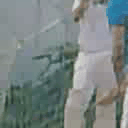

In [249]:
# 准备用于展示 accuracy 的 video
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)
    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                cur_input = preprocess(batch[j, :]).unsqueeze(0).to(device)
                frame_features[i, j, :] = feature_extractor(cur_input).cpu().detach().numpy()

            else:
                frame_features[i, j, :] = 0.0
    return frame_features

def predict_action(path):
    class_vocab = np.unique(train_df["tag"])

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    frame_features_tensor = torch.from_numpy(frame_features).to(device)
    result = best_model(frame_features_tensor[0])
    probabilities = result[0].cpu().detach().numpy()

    for i in np.argsort(probabilities)[::-1]:
        print(f" {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])